In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (assuming CSV format with relevant columns)
df = pd.read_excel("data/log.xlsx")
df = df[['case:concept:name','log','concept:name','time:timestamp']]

In [2]:
df = df.loc[~(df['concept:name'].eq('Anesthesia Ready'))]

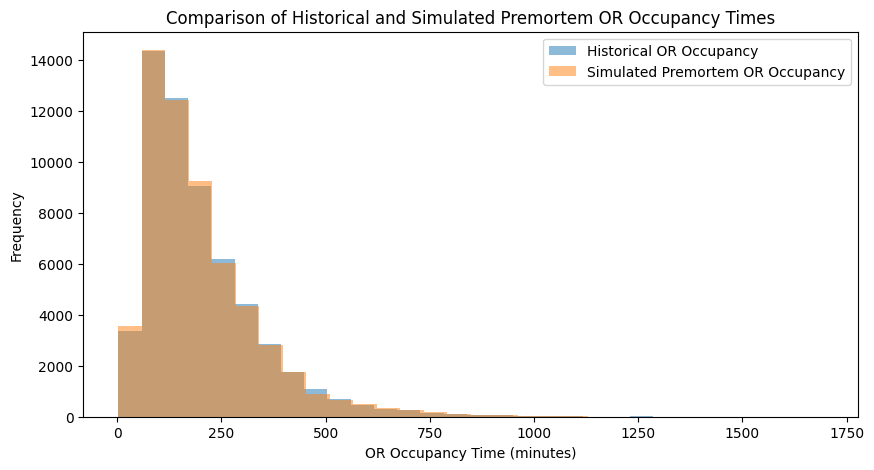

Premortem analysis complete. Simulated dataset saved.


In [3]:

# Pivot the event log to extract relevant timestamps
df_pivot = df.pivot(index=["case:concept:name", "log"], columns="concept:name", values="time:timestamp").reset_index()

# Calculate key time intervals
df_pivot["Anesthesia_Induction_Time"] = (df_pivot["Anesthesia Start"] - df_pivot["Operating Room Enter"]).dt.total_seconds() / 60
df_pivot["Total_OR_Occupancy"] = (df_pivot["Operating Room Exit"] - df_pivot["Operating Room Enter"]).dt.total_seconds() / 60
df_pivot["Postoperative_Recovery_Delay"] = (df_pivot["Anesthesia Stop"] - df_pivot["Operating Room Exit"]).dt.total_seconds() / 60

# Identify historical delays (outliers)
thresh_induction = df_pivot["Anesthesia_Induction_Time"].quantile(0.75) + 1.5 * (df_pivot["Anesthesia_Induction_Time"].quantile(0.75) - df_pivot["Anesthesia_Induction_Time"].quantile(0.25))
thresh_occupancy = df_pivot["Total_OR_Occupancy"].quantile(0.75) + 1.5 * (df_pivot["Total_OR_Occupancy"].quantile(0.75) - df_pivot["Total_OR_Occupancy"].quantile(0.25))

df_pivot["Delayed_Induction"] = df_pivot["Anesthesia_Induction_Time"] > thresh_induction
df_pivot["Excessive_OR_Occupancy"] = df_pivot["Total_OR_Occupancy"] > thresh_occupancy

# Simulate premortem cases: Introduce hypothetical delays
def simulate_premortem(row):
    simulated = row.copy()
    if row["Delayed_Induction"]:
        simulated["Anesthesia_Induction_Time"] += np.random.randint(5, 15)  # Additional delay in minutes
    if row["Excessive_OR_Occupancy"]:
        simulated["Total_OR_Occupancy"] += np.random.randint(10, 30)
    return simulated

premortem_cases = df_pivot.apply(simulate_premortem, axis=1)

# Visualize the impact
plt.figure(figsize=(10,5))
plt.hist(df_pivot["Total_OR_Occupancy"], bins=30, alpha=0.5, label="Historical OR Occupancy")
plt.hist(premortem_cases["Total_OR_Occupancy"], bins=30, alpha=0.5, label="Simulated Premortem OR Occupancy")
plt.xlabel("OR Occupancy Time (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Comparison of Historical and Simulated Premortem OR Occupancy Times")
plt.show()

# Save premortem dataset
premortem_cases.to_csv("premortem_surgery_event_log.csv", index=False)

print("Premortem analysis complete. Simulated dataset saved.")
